# Implement VGG-Net

1. Assert you have the following libraries installed:

> `pip install torch torchvision numpy tqdm ipywidgets matplotlib`

2. All Conv2D are **3x3** with padding **1**, and are followed by a BatchNorm2d (optional) and a **ReLU** activation

3. All MaxPooling are **2x2** with stride **2**

**Block 1**
> + Conv2D 3->64
> + Conv2D 64->64
> + MaxPool

**Block 2**
> + Conv2D 64->128
> + Conv2D 128->128
> + MaxPool

**Block 3**
> + Conv2D 128->256
> + Conv2D 256->256
> + Conv2D 256->256
> + MaxPool

**Block 4**
> + Conv2D 256->512
> + Conv2D 512->512
> + Conv2D 512->512
> + MaxPool

**Block 5**
> + Conv2D 512->512
> + Conv2D 512->512
> + Conv2D 512->512
> + MaxPool

**Classifier**
> + Linear INPUT_SIZE -> 4096 + ReLU
> + Linear 4096 -> 1000 + ReLU
> + Linear 1000 -> OUTPUT SIZE

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import SGD



class VGG16(nn.Module):

    def __init__(self, in_channels: int = 3, num_classes: int = 1000):
        super(VGG16, self).__init__()

        # suggestion: look into nn.Sequential()
        # and divide the convolutional feature extraction part of the net
        # from the final fully-connected classification part
        self.conv_features = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3, padding=1),
          nn.MaxPool2d(2,stride=2),

          nn.Conv2d(64, 128, 3, padding=1),
          nn.ReLU(),
          nn.Conv2d(128, 128, 3, padding=1),
          nn.MaxPool2d(2,stride=2),

          nn.Conv2d(128, 256, 3, padding=1),
          nn.ReLU(),
          nn.Conv2d(256,256,3, padding=1),
          nn.ReLU(),
          nn.Conv2d(256,256,3, padding=1),
          nn.MaxPool2d(2,stride=2),

          nn.Conv2d(256, 512, 3, padding=1),
          nn.ReLU(),
          nn.Conv2d(512,512,3, padding=1),
          nn.ReLU(),
          nn.Conv2d(512,512,3, padding=1),
          nn.MaxPool2d(2,stride=2),

          nn.Conv2d(512, 512, 3, padding=1),
          nn.ReLU(),
          nn.Conv2d(512,512,3, padding=1),
          nn.ReLU(),
          nn.Conv2d(512,512,3, padding=1),
          nn.AdaptiveAvgPool2d(7)
        )
        self.dense = nn.Sequential(
          nn.Linear(7*7*512, 4096),
          nn.ReLU(),
          nn.Linear(4096, 1000),
          nn.ReLU(),
          nn.Linear(1000, num_classes),
          nn.Softmax(dim=1)
        )
        self.num_classes = num_classes
        self.in_channels = in_channels
    def forward(self, x: torch.Tensor):
        x = self.conv_features(x)
        x = torch.flatten(x,1)
        return self.dense(x)
        #return self.net(torch.flatten(x, 1))


# Forward Pass Debug
If it can process random data, then you're mostly alright :D

In [ ]:
import numpy as np


net = VGG16()  # instantiate your net
num_params = sum([np.prod(p.shape) for p in net.parameters()])
print(f"Number of parameters : {num_params}")
print('-' * 50)

# test on Imagenet-like shaped data (224x224)

X = torch.rand((8, 3, 224, 224))
print('output shape for imgnet', net(X).shape)


Number of parameters : 122577232
--------------------------------------------------
output shape for imgnet torch.Size([8, 1000])


In [ ]:
# test on CIFAR-like shaped data (32x32)

X = torch.rand((8, 3, 32, 32))
print('output shape for cifar', net(X).shape)


output shape for cifar torch.Size([8, 1000])


# OPTIONAL: Let's train on CIFAR-10

let's load the dataset

In [ ]:
import torchvision
import torchvision.transforms as transforms

mean = (0.4913997551666284, 0.48215855929893703, 0.4465309133731618)
std = (0.24703225141799082, 0.24348516474564, 0.26158783926049628)

# Choose the appropriate transforms for the problem at hand
# see https://pytorch.org/docs/stable/torchvision/transforms.html
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Let's plot some sample images

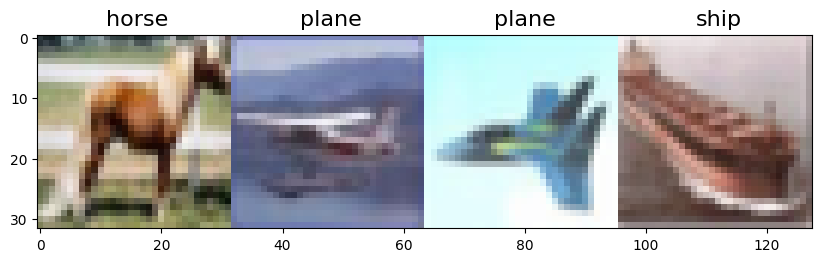

In [ ]:
import matplotlib.pyplot as plt

# get some random training images
images, labels = next(iter(trainloader))
images, labels = images[:4], labels[:4]

# show images
img = torchvision.utils.make_grid(images, padding=0)
img = img * np.array(std)[:, None, None] + np.array(mean)[:, None, None]  # unnormalize
npimg = img.numpy().clip(0, 1)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(npimg, (1, 2, 0)))
for i in range(4):
    ax.text((i + 0.5) * (img.shape[-1] // 4), -2, classes[labels[i]], ha='center', fontsize=16)
plt.show()


In [ ]:
assert torch.cuda.is_available(), "Notebook is not configured properly!"
print('Congrats, you\'re running this code on a', torch.cuda.get_device_name(), 'gpu')
device = 'cuda:0'

#need num of channels and num of classes
net = VGG16(3,10).to(device)  # initialize VGG16 for this specific classification problem

# Nothing works w/o Batch Norm or Proper Initialization


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)


initialize_weights(net)

# define here the Pytorch objects needed for training
crit= nn.CrossEntropyLoss().to(device)
learning_rate = 0.01
opt = SGD(net.parameters(), learning_rate, momentum=0.9)
epochs = 10


Congrats, you're running this code on a Tesla T4 gpu


Training loop

In [ ]:
from tqdm.notebook import tqdm


for e in range(epochs):
    pbar = tqdm(total=len(trainloader), desc=f'Epoch {e}')
    net.train()
    for i, (x, y) in enumerate(trainloader):
        # forward pass goes here
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        y_pred = net(x)
        loss = crit(y_pred, y)
        loss.backward()
        opt.step()
        # logging functions
        pbar.update(1)
        pbar.set_postfix({'Loss': loss.item()})
    pbar.close()

    # evaluation loop
    with torch.no_grad():
        net.eval()
        correct = 0
        for x, y in testloader:
            x,y = x.to(device), y.to(device)
            y_pred = net(x)
            y_pred_discr = torch.argmax(y_pred, dim=1)
            acc = (torch.sum(y_pred_discr == y).float())
            correct += acc
    print(f"Accuracy for epoch {e}: {correct / len(testset):.2%}")


Epoch 0:   0%|          | 0/782 [00:00<?, ?it/s]

Accuracy for epoch 0: 32.54%


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Accuracy for epoch 1: 37.05%


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Accuracy for epoch 2: 30.58%


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Accuracy for epoch 3: 10.01%


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Accuracy for epoch 4: 11.73%


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: ignored